# Pandana network accessibility simple demo

This notebook uses [pandana](https://udst.github.io/pandana/network.html) (v0.2) to download street network and points-of-interest data from OpenStreetMap and then calculate network accessibility to the points of interest. Note: pandana currently only runs on Python 2.
  
For a more in-depth demo, check out [pandana-accessibility-demo-full.ipynb](pandana-accessibility-demo-full.ipynb)

In [6]:
import pandana, matplotlib.pyplot as plt
from pandana.loaders import osm
%matplotlib inline

In [20]:
import matplotlib
print(matplotlib.__version__)
print(pandana.version)

3.0.3
0.3.0


In [7]:
bbox = [48.0616244,11.360777, 48.2481162,  11.7229083]
#[37.76, -122.35, 37.9, -122.17] #lat-long bounding box for berkeley/oakland
amenity = 'pub' #accessibility to this type of amenity
distance = 1500 #max distance in meters

## Download points of interest (POIs) and network data from OpenStreetMap

In [8]:
# first download the points of interest corresponding to the specified amenity type
pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags='"amenity"="{}"'.format(amenity))
pois[['amenity', 'name', 'lat', 'lon']].tail()

,amenity,name,lat,lon
id,,,,
6407360018,pub,Loni,48.129908,11.503141
6420324525,pub,s'Krügerl,48.180436,11.507780
6434248066,pub,Schoppen-Stüberl,48.128052,11.554863
6812337966,pub,NaN,48.224235,11.559390
7128363450,pub,Magic 7,48.146198,11.534542


In [21]:
# query the OSM API for the street network within the specified bounding box
network = osm.network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
pickle.dump(network, open('munich_net.pkl','wb'))
# how many network nodes did we get for this bounding box?
len(network[0].index)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](48.06162440,11.36077700,48.24811620,11.72290830);>;);out;'}"
Downloaded 70,191.4KB from www.overpass-api.de in 9.03 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 11.86 seconds
Returning OSM data with 429,888 nodes and 127,217 ways...
Edge node pairs completed. Took 389.36 seconds
Returning processed graph with 166,546 nodes and 233,718 edges...
Completed OSM data download and Pandana node and edge table creation in 414.19 seconds


166546

In [ ]:
import pickle
#
network = pickle.load(open('munich_net.pkl','rb'))

In [3]:

import pandana as pdna
network=pdna.Network(network[0]["x"], network[0]["y"], 
                     network[1].reset_index()['level_0'], 
                     network[1].reset_index()['level_1'],
                 network[1].reset_index()[["distance"]])

c:\users\mraf\anaconda3\envs\tensorflow\lib\site-packages\pandana\network.py:132: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.as_matrix().astype('float32'),
c:\users\mraf\anaconda3\envs\tensorflow\lib\site-packages\pandana\network.py:133: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix().astype('int32'),
c:\users\mraf\anaconda3\envs\tensorflow\lib\site-packages\pandana\network.py:134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges_df[edge_weights.columns].transpose()


## Process the network data then compute accessibility

In [4]:
# identify nodes that are connected to fewer than some threshold of other nodes within a given distance
# do nothing with this for now, but see full example in other notebook for more
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

In [9]:
# precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [10]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=1, max_dist=distance, max_pois=7)

In [11]:
# initialize a category for this amenity with the locations specified by the lon and lat columns
network.set_pois(category='my_amenity', x_col=pois['lon'], y_col=pois['lat'])

In [12]:
# search for the n nearest amenities to each node in the network
access = network.nearest_pois(distance=distance, category='my_amenity', num_pois=7)

# each df cell represents the network distance from the node to each of the n POIs
access.head()

,1,2,3,4,5,6,7
id,,,,,,,
128221,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
128226,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
128227,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
128228,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
128231,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0


## Plot the accessibility

In [13]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

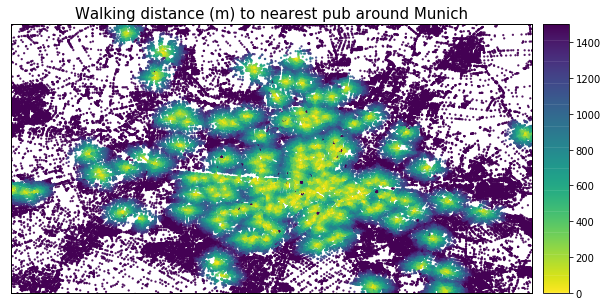

In [15]:
# plot the distance to the nth nearest amenity
n = 1
bmap, fig, ax = network.plot(access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
#ax.set_axis_bgcolor('k')
ax.set_title('Walking distance (m) to nearest {} around Munich'.format(amenity), fontsize=15)
fig.savefig('images/accessibility-pub-east-bay.png', dpi=200, bbox_inches='tight')
plt.show()

3.0.3
0.3.0


For a more in-depth demo, check out [pandana-accessibility-demo-full.ipynb](pandana-accessibility-demo-full.ipynb)